### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Градиентный бустинг


**Общая информация**

**Срок сдачи:** 13 июня 2022, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 13 июня, -4 балла после 08:30 20 июня, -6 баллов после 08:30 24 мая, -8 баллов после 08:30 31 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0422, Задание 4] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Считаем производные для функций потерь (1 балл)

Мы будем реализовать градиентный бустинг для 3 функций потерь:

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

3) Логистическая  $L(a(x_i), y_i) = \log (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

где $a(x_i)$ предсказание бустинга на итом объекте. 

Для каждой функции потерь напишите таргет, на который будет настраиваться каждое дерево в бустинге. 

***Ваше решение тут***

1) MSE  $L(a(x_i), y_i) = (y_i - a(x_i)) ^ 2$

> $-\frac{\partial L(x, y_i)}{\partial x} \big|_{x=F_{k-1}(x_i)} = -\frac{\partial (y_i - x) ^ 2}{\partial x} \big|_{x=F_{k-1}(x_i)} = y_i - F_{k-1}(x_i)$

2) Экспоненциальная  $L(a(x_i), y_i) = exp( -a(x_i) y_i), y_i \in \{-1, 1\}$

> $-\frac{\partial L(x, y_i)}{\partial x} \big|_{x=F_{k-1}(x_i)} = -\frac{\partial e^{xy_i}}{\partial x} \big|_{x=F_{k-1}(x_i)} = e^{-x y_i}y_i$

3) Логистическая  $L(a(x_i), y_i) = \ln (1 + exp( -a(x_i) y_i)), y_i \in \{-1, 1\}$

> $-\frac{\partial L(x, y_i)}{\partial x} \big|_{x=F_{k-1}(x_i)} = -\frac{\partial \ln (1 + exp( -x y_i))}{\partial x} \big|_{x=F_{k-1}(x_i)} = \frac{y_i}{e^{xy_i} + 1}$

##  Реализуем градиентный бустинг (3 балла)

Реализуйте класс градиентного бустинга для классификации. Ваша реализация бустинга должна работать по точности не более чем на 5 процентов хуже чем GradientBoostingClassifier из sklearn. 


Детали реализации:

-- должно поддерживаться 3 функции потерь

-- сами базовые алгоритмы(деревья, линейные модели и тп) реализовать не надо, просто возьмите готовые из sklearn

-- в качестве функции потерь для построения одного дерева используйте MSE

-- шаг в бустинге можно не подбирать, можно брать константный

-- можно брать разные модели в качестве инициализации бустинга

-- должны поддерживаться следующие параметры:

а) число итераций
б) размер шага
в) процент случайных фичей при построении одного дерева
д) процент случайных объектов при построении одного дерева
е) параметры базового алгоритма (передавайте через **kwargs)

In [1]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

from sklearn.datasets import load_wine
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
class MyGradientBoostingClassifier:

    def __init__(
                 self,
                 loss='mse',
                 learning_rate=0.1,
                 n_estimators=100,
                 colsample=1.0,
                 subsample=1.0,
                 *args,
                 **kwargs
                ):
        """
        loss -- один из 3 лоссов:
        learning_rate -- шаг бустинга
        n_estimators -- число итераций
        colsample -- процент рандомных признаков при обучении одного алгоритма
        subsample -- процент рандомных объектов при обучении одного алгоритма
        args, kwargs -- параметры  базовых моделей
        """
        # Ваш код здесь
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.colsample = colsample
        self.subsample = subsample
        self.model_args = args
        self.model_kwargs = kwargs
        # Список обученных моделей
        self.models = []

    def get_samples(self, X, y):
        objects = np.random.permutation(X.shape[0])
        objects = objects[:int(self.subsample * X.shape[0])]
        variables = np.random.permutation(X.shape[1])
        variables = np.sort(variables[:int(self.colsample * X.shape[1])])
        return X[objects, :][:, variables], y[objects], variables
        
    def init_model_predict(self, X):
        predict = getattr(self.init_model, 'predict', None)
        if callable(predict):
            return self.init_model.predict(X)
        else:
            return np.zeros(X.shape[0]) + self.init_model
    
    def calc_grad(self, X, y):
        prediction = self.predict(X)

        if self.loss == 'log_loss':
            return np.round(y / (np.exp(prediction * y) + 1))
        
        if self.loss == 'mse':
            return np.round(y - prediction)
        
        if self.loss == 'exponential':
            return np.round(np.exp(-prediction * y) * y)
        
    
    def fit(self, X, y, base_model=DecisionTreeClassifier, init_model=None):
        """
        X -- объекты для обучения:
        y -- таргеты для обучения
        base_model -- класс базовых моделей, например sklearn.tree.DecisionTreeRegressor
        init_model -- класс для первой модели, если None то берем константу (только для посл задания)
        """
        # Ваш код здесь
        X = np.copy(X)
        y = np.copy(y)
        self.init_model = init_model
        if init_model is None:
            if self.loss == 'mse':
                self.init_model = np.mean(y)
            else:
                self.init_model = 1
        else:
            self.init_model = init_model()
            self.init_model.fit(X, y)
        
        for i in range(self.n_estimators):
            model = base_model(*self.model_args, **self.model_kwargs)
            grad_y = self.calc_grad(X, y)

            sample_X, sample_y, model_vars = self.get_samples(X, grad_y)
            model.variables = model_vars

            model.fit(sample_X, sample_y)
            self.models.append(model)
        
    def predict(self, X):
        # Ваш код здесь
        predictions = np.float64(self.init_model_predict(X))
        for model in self.models:
            predictions += (model.predict(X[:, model.variables]) * self.learning_rate)
        
        if self.loss == 'mse':
            prediction = np.round(predictions)
        else:
            prediction = np.sign(predictions)
        return prediction

In [73]:
my_clf = MyGradientBoostingClassifier()
clf = GradientBoostingClassifier()

In [76]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [77]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

print(accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print(accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

1.0
1.0


## Подбираем параметры (2 балла)

Давайте попробуем применить Ваш бустинг для предсказаний цены домов в Калифорнии. Чтобы можно было попробовтаь разные функции потерь, переведем по порогу таргет в 2 класса: дорогие и дешевые дома.

В задании нужно

1) Построить график точности в зависимости от числа итераций на валидации.

2) Подобрать оптимальные параметры Вашего бустинга на валидации. 


In [6]:
from sklearn.datasets import fetch_california_housing
X, y = fetch_california_housing(return_X_y=True)

In [7]:
# Превращаем регрессию в классификацию
y = (y > 2.0).astype(int)
# Тагретом будут два класса y = {-1, 1}
y[y == 0] = -1
print(X.shape, y.shape)

(20640, 8) (20640,)


In [8]:
clf = MyGradientBoostingClassifier()
clf.fit(X_train, y_train)
initial_accuracy = accuracy_score(y_test, clf.predict(X_test))
initial_accuracy

0.7777777777777778

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
best_args = {}

In [28]:
n_estimators = []
n_accuracy = []
for n in tqdm.tqdm(range(10, 200, 10)):
    n_estimators.append(n)
    clf = MyGradientBoostingClassifier(n_estimators=n)
    clf.fit(X_train, y_train)
    n_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 19/19 [01:38<00:00,  5.16s/it]


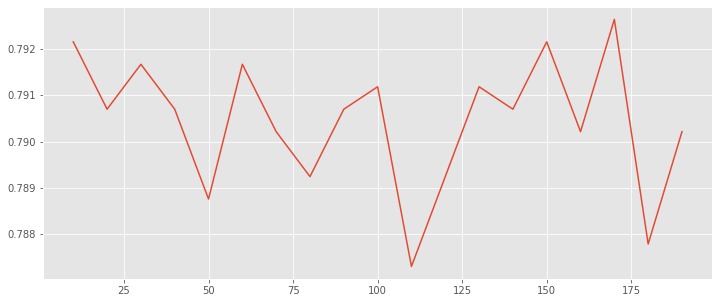

In [29]:
fig, ax = plt.subplots()
ax.plot(n_estimators, n_accuracy)
best_args['n_estimators'] = n_estimators[np.argmax(n_accuracy)]

In [30]:
losses = ['log_loss', 'mse', 'exponential']
loss_accuracy = []
for loss in tqdm.tqdm(losses):
    clf = MyGradientBoostingClassifier(loss=loss, **best_args)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    loss_accuracy.append(accuracy_score(y_test, prediction))

100%|██████████| 3/3 [00:30<00:00, 10.23s/it]


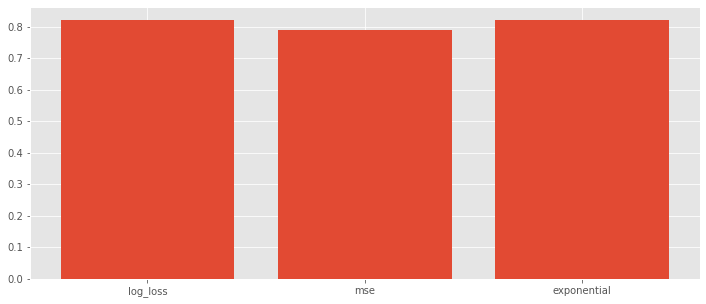

In [31]:
fig, ax = plt.subplots()
ax.bar(losses, loss_accuracy)
best_args['loss'] = losses[np.argmax(loss_accuracy)]

In [32]:
learning_rates = list(np.arange(0.1, 0.6, 0.1))
lrate_accuracy = []
for rate in tqdm.tqdm(learning_rates):
    clf = MyGradientBoostingClassifier(learning_rate=rate, **best_args)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    lrate_accuracy.append(accuracy_score(y_test, prediction))

100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


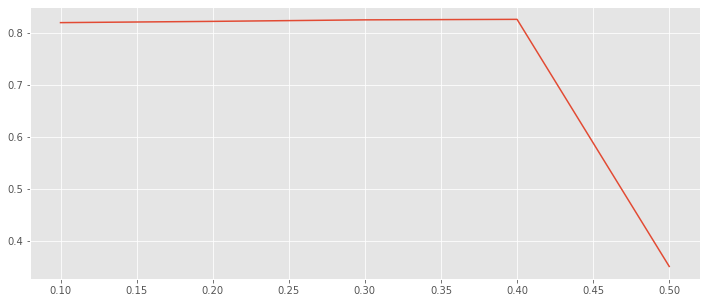

In [33]:
fig, ax = plt.subplots()
ax.plot(learning_rates, lrate_accuracy)
best_args['learning_rate'] = learning_rates[np.argmax(lrate_accuracy)]

In [34]:
colsub_samples = list(np.arange(0.3, 1.1, 0.1))
colsub_accuracy = []
for colsub in tqdm.tqdm(colsub_samples):
    clf = MyGradientBoostingClassifier(colsample=colsub, subsample=colsub, **best_args)
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    colsub_accuracy.append(accuracy_score(y_test, prediction))

100%|██████████| 8/8 [01:08<00:00,  8.62s/it]


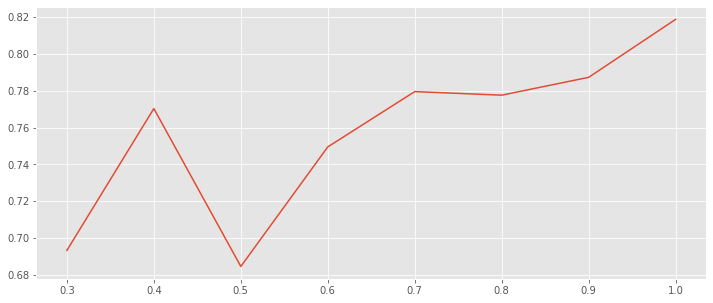

In [35]:
fig, ax = plt.subplots()
ax.plot(colsub_samples, colsub_accuracy)
best_args['colsample'] = colsub_samples[np.argmax(colsub_accuracy)]
best_args['subsample'] = colsub_samples[np.argmax(colsub_accuracy)]

***Результат:***  

Подобрав оптимальные параметры для градиентного бустинга:

In [38]:
best_args

{'n_estimators': 170,
 'loss': 'log_loss',
 'learning_rate': 0.4,
 'colsample': 1.0000000000000002,
 'subsample': 1.0000000000000002}

удалось улучшить точность модели на

In [39]:
np.max(colsub_accuracy) - initial_accuracy

0.04102067183462532

## BooBag BagBoo (1 балл)



Попробуем объединить бустинг и бэгинг. Давайте

1) в качестве базовой модели брать не дерево решений, а случайный лес (из sklearn)

2) обучать N бустингов на бустрапированной выборке, а затем предикт усреднять

Попробуйте обе этих стратегии на данных из прошлого задания. Получилось ли улучшить качество? Почему?

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [21]:
clf = MyGradientBoostingClassifier(n_estimators=10)
clf.fit(X_train, y_train, base_model=RandomForestClassifier, )
random_forest_accuracy = accuracy_score(y_test, clf.predict(X_test))
random_forest_accuracy

0.8624031007751938

In [22]:
n_classifiers = 10
classifiers = [MyGradientBoostingClassifier() for _ in range(n_classifiers)]
for clf in classifiers:
    objects = np.random.permutation(X_train.shape[0])
    objects = objects[:X_train.shape[0]//2]
    clf.fit(X_train[objects], y_train[objects])

prediction = np.zeros(X_test.shape[0])
for clf in classifiers:
    prediction += clf.predict(X_test)
prediction = np.sign(prediction)
bagboo_accuracy = accuracy_score(y_test, prediction)
bagboo_accuracy

0.8706395348837209

Да, качество получилось улучшить за счет обучения сильно большего количества моделей, но жертвуя производительностью.

## Умная инициализация (1 балл)

Попробуйте брать в качестве инициализации бустинга не константу, а какой-то алгоритм и уже от его предикта стартовать итерации бустинга. Попробуйте разные модели из sklearn: линейные модели, рандом форест, svm..

Получилось ли улучшить качество? Почему?



In [23]:
from sklearn.linear_model import SGDClassifier

In [24]:
init_models = [RandomForestClassifier, SGDClassifier, DecisionTreeClassifier]
init_models_labels = ['Random Forest', 'Linear Model', 'Decision Tree']
models_accuracy = []

for model in tqdm.tqdm(init_models):
    clf = MyGradientBoostingClassifier()
    clf.fit(X_train, y_train, init_model=model)
    models_accuracy.append(accuracy_score(y_test, clf.predict(X_test)))

100%|██████████| 3/3 [00:46<00:00, 15.55s/it]


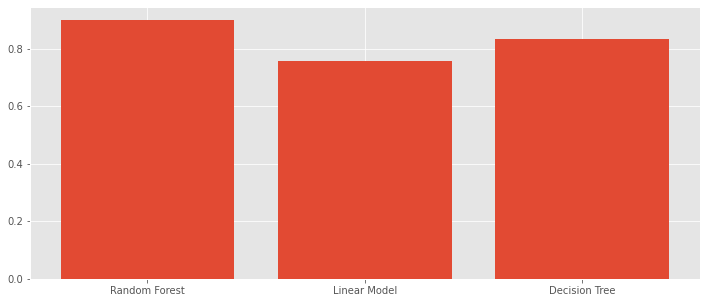

In [25]:
fig, ax = plt.subplots()
ax.bar(init_models_labels, models_accuracy)
plt.show()

## Фидбек (бесценно)

* Какие аспекты обучения  ансамблей Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

